In [1]:
import funs
import funs.model as model

import torch
import os

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from sklearn.model_selection import train_test_split

In [2]:
config = funs.load_yaml('./config.yaml')

funs.set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

aEp = 1

device = cuda


In [3]:
# name setting
model_name = f'ST_FRFconv-TDS_{aEp}'
log_file = f'ST_log_per_acc_{aEp}.txt'
cm_name = f'ST_confusion_matrix_{aEp}.png'

In [4]:
data_root_dirs = os.path.join(config.dataset_root_st)

print("Making dataframes...")

df =funs.STmake_dataframe(config, data_root_dirs)

Making dataframes...


In [5]:
df

,data,fault_type,label,RPM,bearing_type
0,"[0.10166104, 0.0548054, 0.02819829, 0.01743572...",H,0,1400,DeepGrooveBall
1,"[-0.33644316, -0.34071583, -0.35663059, -0.361...",H,0,1400,DeepGrooveBall
2,"[-0.17147417, -0.1711199, -0.16059555, -0.1558...",H,0,1400,DeepGrooveBall
3,"[-0.20658688, -0.22301783, -0.24669302, -0.246...",H,0,1400,DeepGrooveBall
4,"[-0.24280824, -0.20126364, -0.17734106, -0.198...",H,0,1400,DeepGrooveBall
...,...,...,...,...,...
23995,"[-0.02151291, -0.0197446, -0.0085056, -0.01035...",U2,6,1400,DeepGrooveBall
23996,"[-0.08810094, -0.17232321, -0.18809751, -0.208...",U2,6,1400,DeepGrooveBall
23997,"[-0.05629579, -0.06596805, -0.07581134, -0.078...",U2,6,1400,DeepGrooveBall
23998,"[0.02883964, 0.026488, 0.0452553, 0.06303003, ...",U2,6,1400,DeepGrooveBall


In [6]:
df['label'].value_counts()

0    3000
5    3000
4    3000
7    3000
3    3000
2    3000
1    3000
6    3000
Name: label, dtype: int64

In [7]:
train_df, temp_df = train_test_split(
    df, 
    test_size=0.4,      # 40%를 val+test로 남김
    stratify=df['label'], 
    random_state=config.seed
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5,      # 남은 40% 중 절반씩
    stratify=temp_df['label'], 
    random_state=config.seed
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [8]:
train_data, train_label = funs.STbuild_from_dataframe(train_df, config.sample_size, config.overlap, False)
val_data, val_label = funs.STbuild_from_dataframe(val_df, config.sample_size, config.overlap, False)
test_data, test_label = funs.STbuild_from_dataframe(test_df, config.sample_size, config.overlap, False)

In [12]:
# np -> tensor transform
tf_data = transforms.Compose([funs.processing.NpToTensor(), funs.processing.ToSignal()])
tf_label = transforms.Compose([funs.processing.NpToTensor()])

In [13]:
train_dataset = funs.NumpyDataset(train_data, train_label, transform=tf_data, target_transform=tf_label)
val_dataset = funs.NumpyDataset(val_data, val_label, transform=tf_data, target_transform=tf_label)
test_dataset = funs.NumpyDataset(test_data, test_label, transform=tf_data, target_transform=tf_label)

train_loader = funs.get_dataloader(train_dataset, config.batch_size, True)
val_loader = funs.get_dataloader(val_dataset, config.batch_size, False)
test_loader = funs.get_dataloader(test_dataset, config.batch_size, False)

In [16]:
n_classes = df["label"].max() - df["label"].min() + 1
model = model.Mynet2(n_classes=n_classes).to(device)

In [21]:
optimizer = Adam(model.parameters(), lr = float(config.learning_rate))
loss = CrossEntropyLoss()

In [22]:
trainer = funs.Trainer(model, loss, optimizer, device, train_loader, val_loader)
train_loss, val_loss = trainer.train(aEp)
trainer.save(config.model_root_st, model_name)

model_path = f'{config.model_root_st}/{model_name}.pt'
trainer.model.load_state_dict(torch.load(model_path, weights_only=True))

fault_label_list, val_loss, predicted_label_list = trainer.test(test_loader) 


Starting Training... 
----------------------------------------
[EPOCH: 0] 
Train Loss: 1.79877
Train Acc: 0.33958
Validation Loss: 1.35633
----------------------------------------
[EPOCH: 1] 
Train Loss: 0.51994
Train Acc: 0.80368
Validation Loss: 0.29738
----------------------------------------

Starting Test... 
----------------------------------------
Test Loss: 0.28740


Class-wise Accuracy:
Class 0: 0.99500
Class 1: 0.99167
Class 2: 0.98333
Class 3: 0.62167
Class 4: 0.58667
Class 5: 0.96167
Class 6: 0.99000
Class 7: 0.96167
Mean Class Accuracy: 0.88646
Class-wise accuracy logged to ST_log_per_acc_1.txt


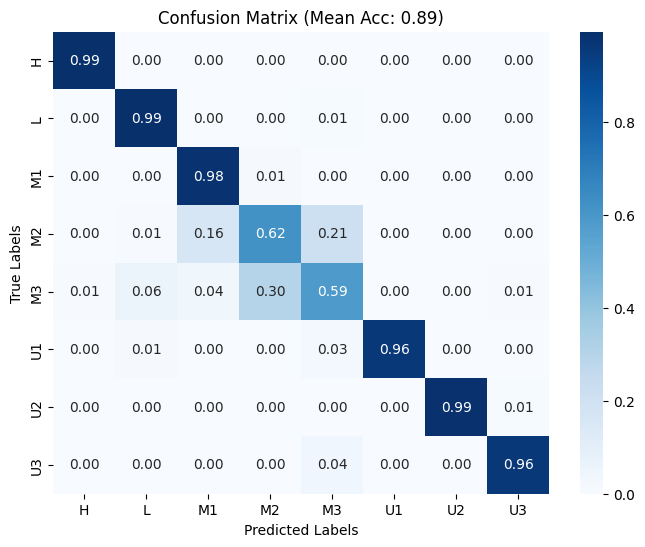

In [23]:
# acc per class logging
funs.log_class_acc(config.log_root_st, fault_label_list, predicted_label_list, f'{log_file}')

# confusion matrix plot
funs.plot_confusion_matrix(config.pic_root_st ,fault_label_list, predicted_label_list, cm_name)